2025-02-04 14:31:28.219720: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 14:31:28.265980: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-04 14:31:28.265999: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-04 14:31:28.266005: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 14:31:28.272846: I tensorflow/core/platform/cpu_feature_g

Using GPU package(s): ['TENSORFLOW']
Retrieved 744 data points, beginning calculation
CPU time: 0.0003 seconds


2025-02-04 14:31:33.224698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 14:31:33.257459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 14:31:33.257787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

GPU time: 1.2345 seconds


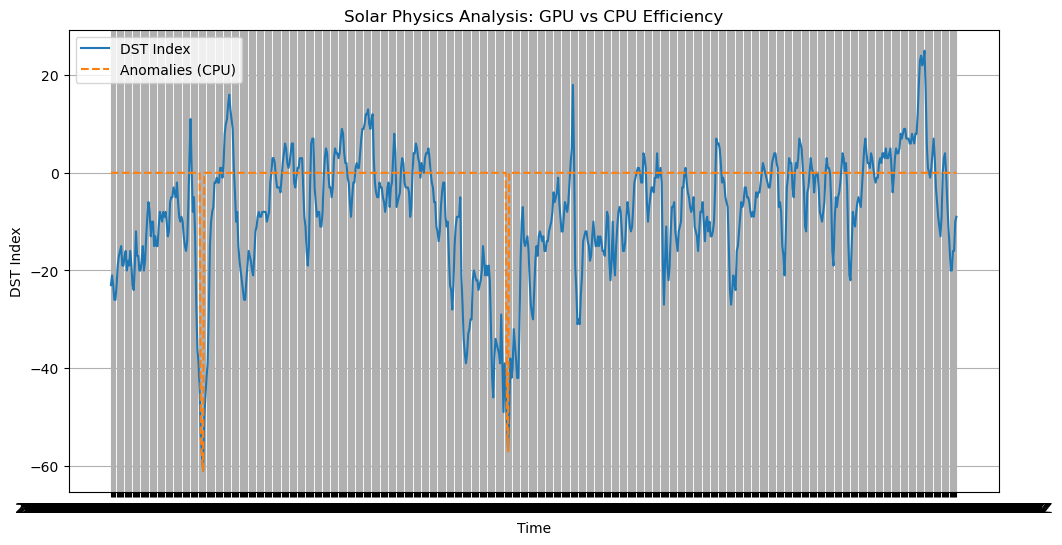

In [1]:
"""                                                                                                           
Simple anomaly detection using DST data, comparing CPU and GPU timing.                                        
                                                                                                              
code derived from ChatGTP4o query, prompt was "Write Python code for a very short demo that shows how you can\
 use GPUs more efficiently than CPUs.  The problem space is solar physics analysis and it should use real OMN\
IWeb DST data fetched via HAPI."                                                                              
Errors from ChatGPT included:                                                                                 
(a) using  'meta, data'  instead of 'data, meta' in HAPI call                                                 
(b) odd use of var names 'params' and 'server' in the HAPI call instead of conventional 'server' and 'dataset\
'                                                                                                             
(c) extraneous import of h5py                                                                                 
                                                                                                              
ChatGPT: meta, data = hapi(data_url, server, params, start_time, end_time)                                    
HAPI convention: data, meta = hapi(server, dataset, parameters, start, stop)                                  
                                                                                                              
Rotates among up to 3 GPU packages, if installed: CuPy, PyTorch, and TensorFlow

For initial test of 744 data particles, so far CPU >> TensorFlow (!)

"""

import numpy as np
import matplotlib.pyplot as plt
ACCELERATORS = []
try:
    import cupy as cp
    ACCELERATORS.append("CUPY")
except:
    pass
try:
    import torch
    ACCELERATORS.append("PYTORCH")
except:
    pass
try:
    import tensorflow as tf
    ACCELERATORS.append("TENSORFLOW")
except:
    pass
print(f"Using GPU package(s): {ACCELERATORS}")
        
from hapiclient import hapi
import time

# Fetch OMNIWeb DST data using HAPI                                                                           
data_url = "https://cdaweb.gsfc.nasa.gov/hapi"
params = "DST1800"
server = "OMNI2_H0_MRG1HR"
start_time = "2023-01-01T00:00:00Z"
end_time = "2023-01-31T23:59:59Z"

# Retrieve data                                                                                               
data, meta = hapi(data_url, server, params, start_time, end_time)
time_data = data['Time']
dst_data = data[params]
print(f"Retrieved {len(data)} data points, beginning calculation")
# Define computation: simple DST anomaly detection                                                            
threshold = -50

# CPU-based computation                                                                                       
def compute_anomalies_cpu(dst):
    return np.where(dst < threshold, dst, 0)

# GPU-based computation                                                                                       
def compute_anomalies_gpu(dst,accel):
    if accel == "CUPY":
        dst_gpu = cp.array(dst)
        anomalies = cp.where(dst_gpu < threshold, dst_gpu, 0)
        return cp.asnumpy()
    elif accel == "PYTORCH":
        dst_gpu = torch.tensor(dst, device='cuda')
        anomalies = torch.where(dst_gpu < threshold, dst_gpu, torch.tensor(0.0, device='cuda'))
        return anomalies.cpu.numpy()
    elif accel == "TENSORFLOW":
        dst_gpu = tf.constant(dst, dtype=tf.float32)
        anomalies = tf.where(dst_gpu < threshold, dst_gpu, tf.constant(0.0))
        return anomalies.numpy()
    return None

# Time CPU computation                                                                                        
start_cpu = time.time()
anomalies_cpu = compute_anomalies_cpu(dst_data)
cpu_time = time.time() - start_cpu
print(f"CPU time: {cpu_time:.4f} seconds")

# Time GPU computation
for accel in ACCELERATORS:
    start_gpu = time.time()
    anomalies_gpu = compute_anomalies_gpu(dst_data, accel)
    gpu_time = time.time() - start_gpu
    print(f"GPU time: {gpu_time:.4f} seconds")

# Plot results                                                                                                
plt.figure(figsize=(12, 6))
plt.plot(time_data, dst_data, label='DST Index')
plt.plot(time_data, anomalies_cpu, label='Anomalies (CPU)', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('DST Index')
plt.legend()
plt.title('Solar Physics Analysis: GPU vs CPU Efficiency')
plt.grid()
plt.show()